# Part 2

## Modeling using machine learning 

In [1]:
! pip install seaborn
! pip install statsmodels
! pip install contextily

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [2]:
import requests
import json
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import fiona
import contextily as ctx
# import distancerasters as dr
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Preparing training data


Training data was obtained through visual inspection, and local data from Accra Metropolitan Assembly

#### Land use labels
 | land use labels | ID | Description |
 | :-: | :-: | :-:| 
 | Slum | 1 | known derpived locations |
 | B_type 1 | 2  | high density residential |
 | B_type 2 | 3  | low density residnetial |
 | Vegetation | 4 | vegetation (grass, Trees) |
 | Bare | 5 | soil, soil play fields

In [3]:
lc = gpd.read_file('./Data/train.shp')
lc.head(5)

,cat,class,geometry
0,1,slum,"POLYGON ((-0.19924 5.58684, -0.19475 5.58440, ..."
1,1,slum,"POLYGON ((-0.19068 5.59266, -0.19291 5.59091, ..."
2,1,slum,"POLYGON ((-0.20432 5.58025, -0.20781 5.58216, ..."
3,1,slum,"POLYGON ((-0.21129 5.59688, -0.20952 5.59532, ..."
4,1,slum,"POLYGON ((-0.23741 5.55977, -0.23355 5.55797, ..."


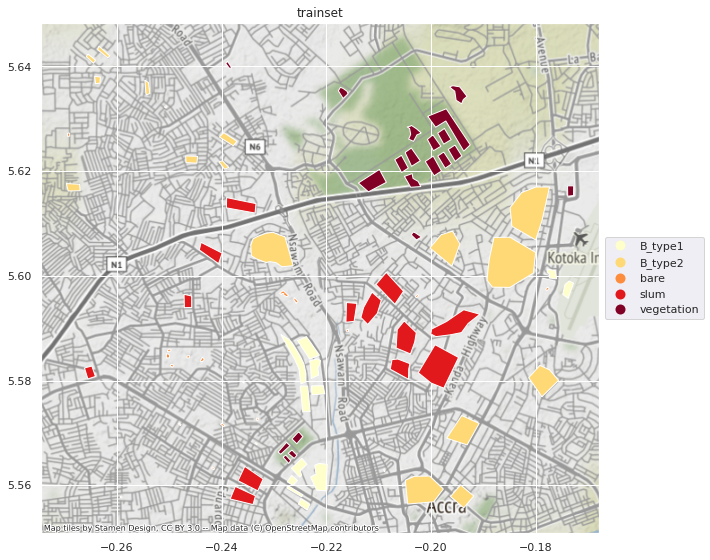

In [4]:
# Plot trainset 

fig, axes = plt.subplots(figsize=(10, 10), sharex=True)  
axes.set_title('trainset') 
lc.plot(ax=axes, column= 'class',  \
            cmap='YlOrRd', legend=True,
            legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)},
         )
ctx.add_basemap(ax=axes, crs=lc.crs)
plt.show()

In [5]:
lc.groupby(['class'],as_index=False).agg('count')

,class,cat,geometry
0,B_type1,12,12
1,B_type2,16,16
2,bare,20,20
3,slum,13,13
4,vegetation,20,20


In [13]:
# Preparing our dataset for modeling 

from glob import glob

# getting list of sentinel-2 bands
filelist1 = sorted(glob('./Data/img/*.tiff'))
print(filelist1)

filelist2 = sorted(glob('./output/*.tif'))
print(filelist2)

fp = filelist1+filelist2
print(fp)

# setting outfile name
bandname1 = []
    # loop from input 
for file in filelist1:
    head, tail = os.path.split(file)
    col_names=tail[:-5]
    bandname1.append(col_names)
print(bandname1)

bandname2 = []
    # loop from input 
for file in filelist2:
    head, tail = os.path.split(file)
    col_names=tail[:-4]
    bandname2.append(col_names)
print(bandname2)

bandnames = bandname1 + bandname2
print(bandnames)

['./Data/img/B02.tiff', './Data/img/B03.tiff', './Data/img/B04.tiff', './Data/img/B08.tiff']
['./output/highway.tif', './output/industry.tif', './output/market.tif', './output/ndvi.tif']
['./Data/img/B02.tiff', './Data/img/B03.tiff', './Data/img/B04.tiff', './Data/img/B08.tiff', './output/highway.tif', './output/industry.tif', './output/market.tif', './output/ndvi.tif']
['B02', 'B03', 'B04', 'B08']
['highway', 'industry', 'market', 'ndvi']
['B02', 'B03', 'B04', 'B08', 'highway', 'industry', 'market', 'ndvi']


In [8]:
filelist1 = sorted(glob('./Data/img/*.tiff'))
print(filelist1)

In [10]:
import geowombat as gw
import os

outfile = './output/acc_bgrn_ndvi_stack.tiff'

with gw.config.update(ref_image=filelist1[0]):
    with gw.open(filelist1, stack_dim= 'band') as src:
        src.gw.to_raster(outfile, overwrite = True)

100%|██████████| 29/29 [00:04<00:00,  6.63it/s]


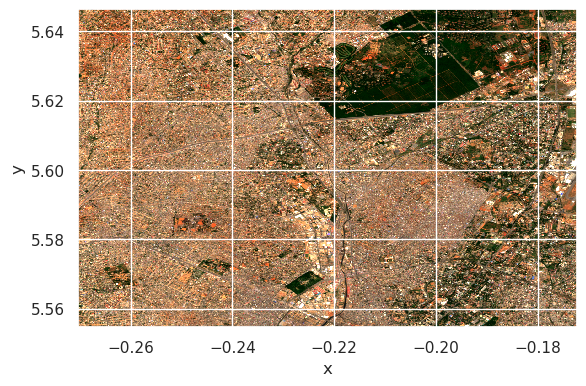

In [11]:
# Visualise the image in True color composite

import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=100)
with gw.open(outfile) as src:
    src.sel(band=[3,2,1]).plot.imshow(robust = True,ax=ax)
plt.tight_layout(pad = 1)

In [13]:
fp = ['./Data/img/B02.tiff', './Data/img/B03.tiff', './Data/img/B04.tiff', './Data/img/B08.tiff', './Data/img/ndvi.tiff', './Data/img/highway.tiff', './Data/img/industry.tiff', './Data/img/market.tiff']

In [14]:
# Extract band values to shapefile
with gw.config.update(ref_image=filelist1[0]):
    with gw.open(fp, stack_dim= 'band') as src: 
        df = src.gw.extract(lc,  
                       band_names=src.band.values.tolist(),all_touched = True)

df.columns = ['id','point','geometry','cat','class','B02','B03','B04','B08','highway','industry','market','ndvi']
df.head()


RasterioIOError: ./Data/img/NDVI.tiff: No such file or directory

In [25]:
# convert euclidean distance from meters to kilometers
df['highway'] = df['highway']*0.001
df['industry'] = df['industry']*0.001
df['market'] = df['market']*0.001
df.head()

,id,point,geometry,cat,class,B02,B03,B04,B08,highway,industry,market,ndvi
0,0,0,POINT (-0.26722 5.64639),1,slum,0.0787,0.1162,0.1378,0.2999,0.003827,4.002268,4.410216,0.370345
1,0,1,POINT (-0.26713 5.64639),1,slum,0.0568,0.0934,0.0921,0.3204,0.003819,3.993257,4.407537,0.553455
2,0,2,POINT (-0.26704 5.64639),1,slum,0.0496,0.0845,0.0710,0.3247,0.003810,3.984249,4.404879,0.641142
3,0,3,POINT (-0.26731 5.64630),1,slum,0.0656,0.0920,0.1450,0.2261,0.003831,4.007090,4.403305,0.218539
4,0,4,POINT (-0.26722 5.64630),1,slum,0.0747,0.1153,0.1489,0.2705,0.003822,3.998065,4.400599,0.289938


 # Statisitics 

In [38]:
# recode to build logistics regression
# 1 = nonslum , 2 =slums
# THIS IS WRONG,CLASS 3 IS SLUM

def reclass(row):
    reclass = row['cat']
    if reclass == 1: return 2
    if reclass == 2: return 1
    if reclass == 3: return 1
    if reclass == 4: return 1
    if reclass == 5: return 1
    return reclass
df['reclass'] = df.apply(reclass, axis=1)

In [40]:
from statsmodels.formula.api import mnlogit  
modellogit = mnlogit(formula='reclass ~ highway+industry+market+ndvi', data=df).fit()
print( modellogit.summary() )

         Current function value: 0.593987
         Iterations: 35


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                          MNLogit Regression Results                          
Dep. Variable:                reclass   No. Observations:                77795
Model:                        MNLogit   Df Residuals:                    77790
Method:                           MLE   Df Model:                            4
Date:                Mon, 02 May 2022   Pseudo R-squ.:               -0.005464
Time:                        13:33:32   Log-Likelihood:                -46209.
converged:                      False   LL-Null:                       -45958.
Covariance Type:            nonrobust   LLR p-value:                     1.000
 reclass=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -14.7526      1.330    -11.095      0.000     -17.359     -12.146
highway    -3.703e+04   3900.632     -9.493      0.000   -4.47e+04   -2.94e+04
industry      34.5653      3.661      9.442      0.0

The logistic regression shows a negetive slope for highway and positive slope for market, industry ad ndvi. This means poverty levels increase as distance from market and industry increase. there is an inverse relations for highways. NDVI p-value was greater than 0.05 so it's not statistically significant. 

# Assessing separability of the train site

[Text(0.5, 1.0, 'Bare')]

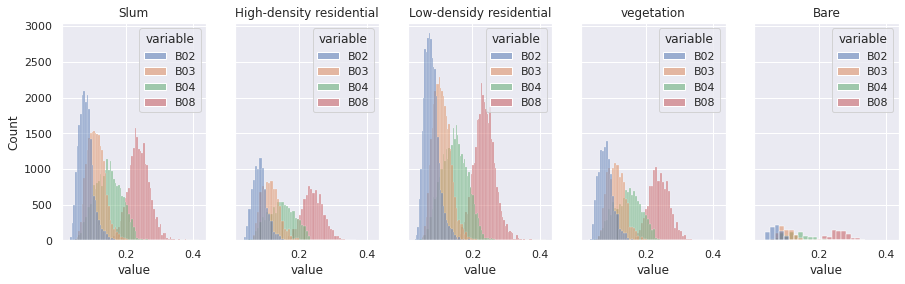

In [43]:
# Histogram of the raw bands

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, nrows=1, figsize=(15, 4), sharey=True, sharex=True)

sns.histplot(data=pd.melt(df[df['class'] =='slum'], 
                          value_vars=['B02','B03','B04', 'B08']), x="value", 
             hue="variable",ax=ax1).set(title='Slum')
sns.histplot(data=pd.melt(df[df['class'] =='B_type1'], 
                          value_vars=['B02','B03','B04', 'B08']), x="value", 
             hue="variable",ax=ax2).set(title='High-density residential')
sns.histplot(data=pd.melt(df[df['class'] =='B_type2'], 
                          value_vars=['B02','B03','B04','B08']), x="value", 
             hue="variable",ax=ax3).set(title='Low-densidy residential')
sns.histplot(data=pd.melt(df[df['class'] =='vegetation'], 
                          value_vars=['B02','B03','B04','B08']), x="value", 
             hue="variable",ax=ax4).set(title='vegetation')
sns.histplot(data=pd.melt(df[df['class'] =='bare'], 
                          value_vars=['B02','B03','B04','B08']), x="value", 
             hue="variable",ax=ax5).set(title='Bare')
 

[Text(0.5, 1.0, 'Bare')]

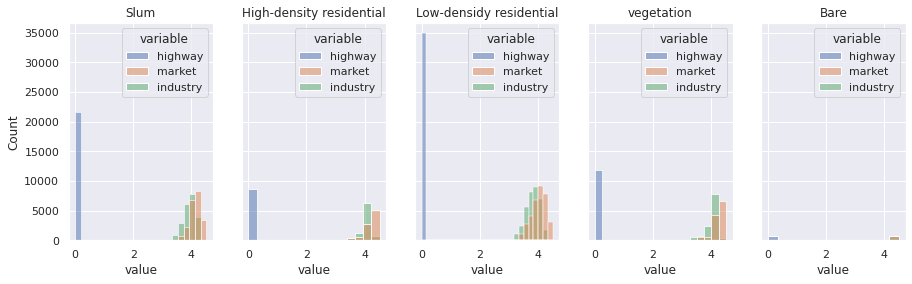

In [45]:
# Histogram of the GIS bands and NDVI

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, nrows=1, figsize=(15, 4), sharey=True, sharex=True)

sns.histplot(data=pd.melt(df[df['class'] =='slum'], 
                          value_vars=['highway','market','industry']), x="value", 
             hue="variable",ax=ax1).set(title='Slum')
sns.histplot(data=pd.melt(df[df['class'] =='B_type1'], 
                          value_vars=['highway','market','industry']), x="value", 
             hue="variable",ax=ax2).set(title='High-density residential')
sns.histplot(data=pd.melt(df[df['class'] =='B_type2'], 
                          value_vars=['highway','market','industry']), x="value", 
             hue="variable",ax=ax3).set(title='Low-densidy residential')
sns.histplot(data=pd.melt(df[df['class'] =='vegetation'], 
                          value_vars=['highway','market','industry']), x="value", 
             hue="variable",ax=ax4).set(title='vegetation')
sns.histplot(data=pd.melt(df[df['class'] =='bare'], 
                          value_vars=['highway','market','industry']), x="value", 
             hue="variable",ax=ax5).set(title='Bare')
 

The histogram shows some distinct and overlapping classes. 

# Machine learning modeling

### Modeling using only the 4 bands and NDVI

In [58]:
# adding x and y coordinate to build ML model 
coord_list = [(x,y) for x,y in zip(df['geometry'].x , df['geometry'].y)]
df[['x','y']] = pd.DataFrame(coord_list, columns = ['x','y'])
df.head()

,id,point,geometry,cat,class,B02,B03,B04,B08,highway,industry,market,ndvi,reclass,x,y
0,0,0,POINT (-0.26722 5.64639),1,slum,0.0787,0.1162,0.1378,0.2999,0.003827,4.002268,4.410216,0.370345,2,-0.267222,5.646394
1,0,1,POINT (-0.26713 5.64639),1,slum,0.0568,0.0934,0.0921,0.3204,0.003819,3.993257,4.407537,0.553455,2,-0.267132,5.646394
2,0,2,POINT (-0.26704 5.64639),1,slum,0.0496,0.0845,0.0710,0.3247,0.003810,3.984249,4.404879,0.641142,2,-0.267042,5.646394
3,0,3,POINT (-0.26731 5.64630),1,slum,0.0656,0.0920,0.1450,0.2261,0.003831,4.007090,4.403305,0.218539,2,-0.267312,5.646305
4,0,4,POINT (-0.26722 5.64630),1,slum,0.0747,0.1153,0.1489,0.2705,0.003822,3.998065,4.400599,0.289938,2,-0.267222,5.646305


In [86]:
X_df = df[['B02','B03','B04', 'B08', 'ndvi', 'x','y']]
y_df = df['cat']

from sklearn.model_selection import train_test_split

# split the data with 75% in training set
X_train, X_test, y_train, y_test = train_test_split( X_df, y_df, 
                                  random_state=0,
                                  train_size=0.75)

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn_xarray.preprocessing import Featurizer
from sklearn.preprocessing import LabelEncoder, StandardScaler


# set_config(display="diagram")
# # set up pipeline
# pipe = Pipeline([('rf', RandomForestClassifier(random_state=0))])

# # possible parameter values to search through
# rf_param_grid = [{'rf__n_estimators':[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)], 
#                   'rf__min_samples_leaf':[1,2],
#                   'rf__max_features': ['auto', 'sqrt']
#                 }]

# # try all possible parameters and do a 5fold CV, choose best
# cv_grid = GridSearchCV( estimator= pipe, param_grid = rf_param_grid, cv=5)
# cv_grid.fit(X_train, y_train)

# Random forest

In [62]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

rfc = RandomForestClassifier(n_estimators=200, max_depth=200, max_features='auto', min_samples_split=3)

rfc.fit(X_train,y_train)
rfc_predict = rfc.predict(X_test)
rfc_cv_score = cross_val_score(rfc, X_test, y_test, cv=10)
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[ 833 1051   84 3330   35]
 [ 536 1296   99  956   35]
 [ 461  947   34  733   24]
 [2072 1087  132 5462   41]
 [   0   89    0    5  107]]


=== Classification Report ===
              precision    recall  f1-score   support

           1       0.21      0.16      0.18      5333
           2       0.29      0.44      0.35      2922
           3       0.10      0.02      0.03      2199
           4       0.52      0.62      0.57      8794
           5       0.44      0.53      0.48       201

    accuracy                           0.40     19449
   macro avg       0.31      0.35      0.32     19449
weighted avg       0.35      0.40      0.37     19449



=== All AUC Scores ===
[0.39125964 0.381491   0.38766067 0.39383033 0.38508997 0.4159383
 0.41233933 0.39485861 0.38868895 0.39506173]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.3946218540734393


# Gradient Boosting classifier

In [88]:
from sklearn.ensemble import GradientBoostingClassifier


gbc = GradientBoostingClassifier()
gbc.fit(X_train,y_train)

gbc_predict = gbc.predict(X_test)
gbc_cv_score = cross_val_score(gbc, X_test, y_test, cv=10)
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, gbc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, gbc_predict))
print('\n')
print("=== All AUC Scores ===")
print(gbc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", gbc_cv_score.mean())

=== Confusion Matrix ===
[[ 712 1104   10 3466   41]
 [ 365 1579   11  926   41]
 [ 308 1031    9  821   30]
 [ 734  984   12 7018   46]
 [   0   78    0    3  120]]


=== Classification Report ===
              precision    recall  f1-score   support

           1       0.34      0.13      0.19      5333
           2       0.33      0.54      0.41      2922
           3       0.21      0.00      0.01      2199
           4       0.57      0.80      0.67      8794
           5       0.43      0.60      0.50       201

    accuracy                           0.49     19449
   macro avg       0.38      0.41      0.36     19449
weighted avg       0.43      0.49      0.42     19449



=== All AUC Scores ===
[0.47609254 0.48534704 0.48534704 0.47969152 0.46735219 0.48997429
 0.46786632 0.48534704 0.47609254 0.49588477]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.48089953135083097


### Modeling using only the 4 bands, NDVI and GIS data

In [89]:
X_df = df[['B02','B03','B04', 'B08', 'ndvi', 'highway','market','industry', 'x','y']]
y_df = df['cat']

from sklearn.model_selection import train_test_split

# split the data with 75% in training set
X_train, X_test, y_train, y_test = train_test_split( X_df, y_df, 
                                  random_state=0,
                                  train_size=0.75)

In [64]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

rfc = RandomForestClassifier(n_estimators=200, max_depth=200, max_features='auto', min_samples_split=3, n_jobs=-1)

rfc.fit(X_train,y_train)
rfc_predict = rfc.predict(X_test)
rfc_cv_score = cross_val_score(rfc, X_test, y_test, cv=10)
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[ 826 1076   89 3303   39]
 [ 510 1323   95  956   38]
 [ 454  956   23  738   28]
 [2062 1112  140 5436   44]
 [   1   88    0    5  107]]


=== Classification Report ===
              precision    recall  f1-score   support

           1       0.21      0.15      0.18      5333
           2       0.29      0.45      0.35      2922
           3       0.07      0.01      0.02      2199
           4       0.52      0.62      0.57      8794
           5       0.42      0.53      0.47       201

    accuracy                           0.40     19449
   macro avg       0.30      0.35      0.32     19449
weighted avg       0.35      0.40      0.36     19449



=== All AUC Scores ===
[0.39434447 0.38920308 0.4        0.40051414 0.40154242 0.41388175
 0.418509   0.38766067 0.38097686 0.39660494]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.39832373290171064


# RF feature of importance

highway     0.177958
y           0.159572
market      0.157057
industry    0.144680
x           0.119376
B08         0.050811
ndvi        0.048855
B02         0.047825
B04         0.047011
B03         0.046856
dtype: float64


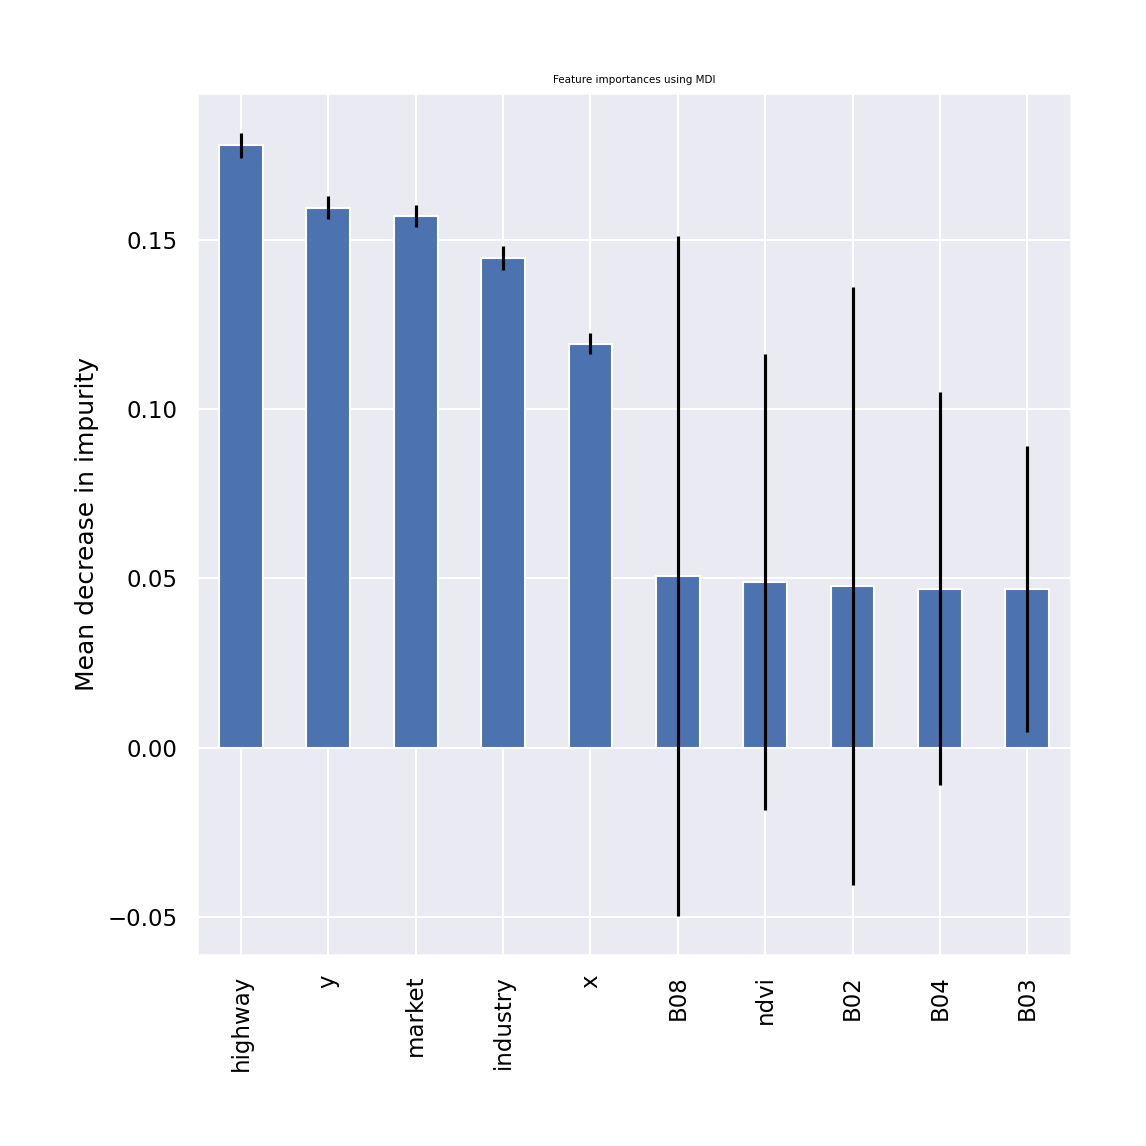

In [84]:
# Feature of importance
filename_list = ['B02','B03','B04', 'B08', 'ndvi', 'highway','market','industry', 'x','y']
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

import pandas as pd
forest_importances = pd.Series(importances, index=filename_list).sort_values(ascending=False)
print(forest_importances)

fig, ax = plt.subplots(figsize = (7,7))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

From the feature of importance, the GIS data seems to contribute more to the model. 

# Gradient Boosting Classifier

In [90]:
from sklearn.ensemble import GradientBoostingClassifier


gbc = GradientBoostingClassifier()
gbc.fit(X_train,y_train)

gbc_predict = gbc.predict(X_test)
gbc_cv_score = cross_val_score(gbc, X_test, y_test, cv=10)
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, gbc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, gbc_predict))
print('\n')
print("=== All AUC Scores ===")
print(gbc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", gbc_cv_score.mean())

=== Confusion Matrix ===
[[ 676 1184   19 3418   36]
 [ 272 1680   14  917   39]
 [ 215 1072   20  867   25]
 [ 620 1106   18 7009   41]
 [   0   83    0    0  118]]


=== Classification Report ===
              precision    recall  f1-score   support

           1       0.38      0.13      0.19      5333
           2       0.33      0.57      0.42      2922
           3       0.28      0.01      0.02      2199
           4       0.57      0.80      0.67      8794
           5       0.46      0.59      0.51       201

    accuracy                           0.49     19449
   macro avg       0.40      0.42      0.36     19449
weighted avg       0.45      0.49      0.42     19449



=== All AUC Scores ===
[0.47403599 0.47455013 0.48174807 0.48329049 0.46580977 0.48946015
 0.47455013 0.48843188 0.47506427 0.4850823 ]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.47920231785627393


# GB feature of importance

highway     0.363748
market      0.231921
y           0.185458
x           0.184100
industry    0.027586
B08         0.002588
B04         0.001329
ndvi        0.001285
B02         0.001284
B03         0.000702
dtype: float64


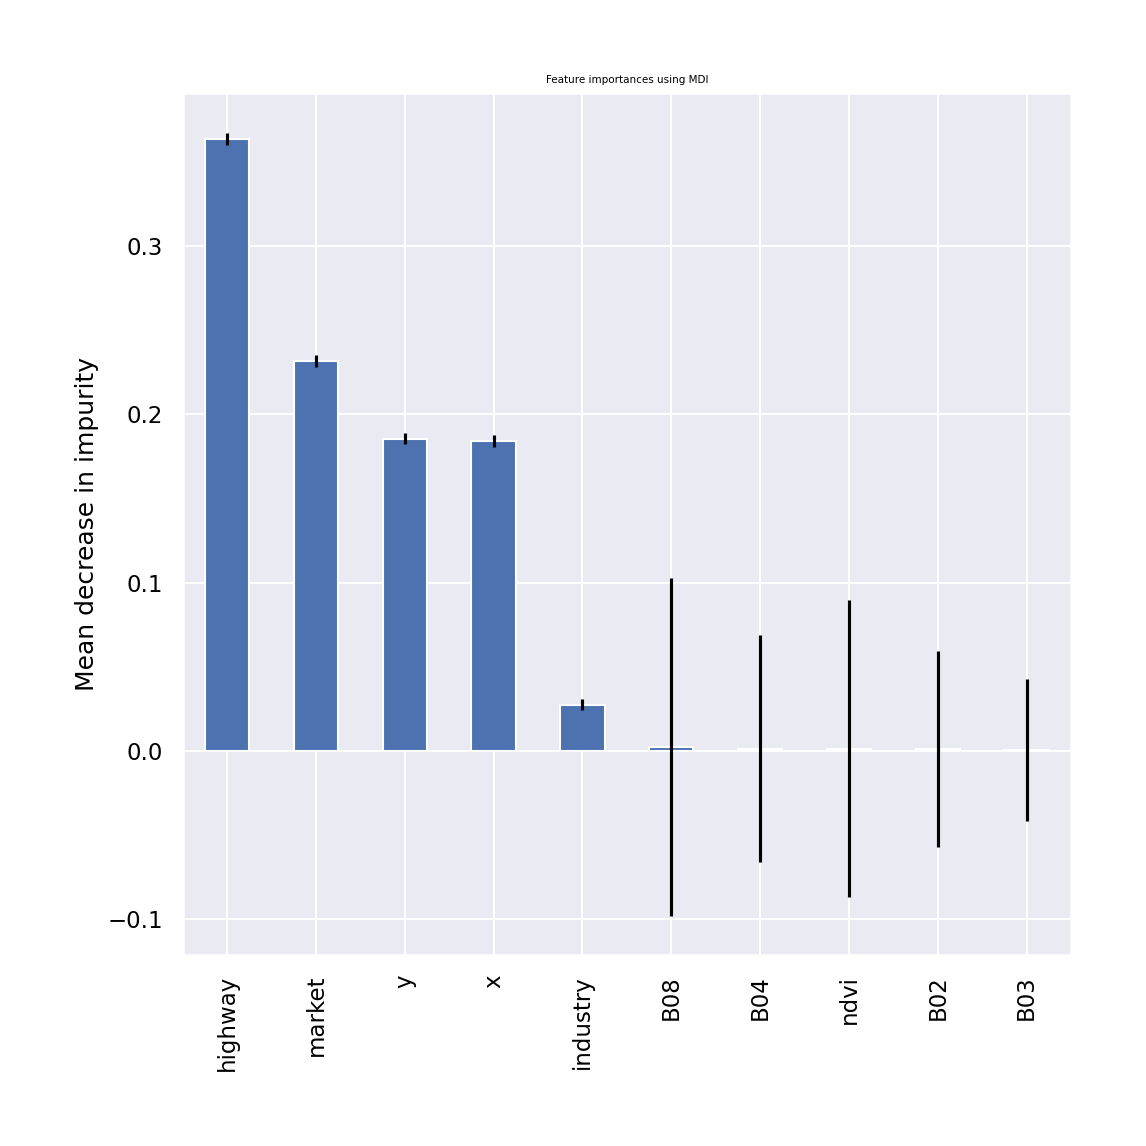

In [96]:
# Feature of importance
filename_list = ['B02','B03','B04', 'B08', 'ndvi', 'highway','market','industry', 'x','y']
importances = gbc.feature_importances_
# std = np.std([tree.feature_importances_ for tree in gbc.estimators_], axis=0)

gb_importances = pd.Series(importances, index=filename_list).sort_values(ascending=False)
print(gb_importances)

fig, ax = plt.subplots(figsize = (7,7))
gb_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

 # Modeling using GeomWombat

In [66]:
from sklearn_xarray.preprocessing import Featurizer
from geowombat.ml import fit, fit_predict
from sklearn.decomposition import PCA 
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier


# Random forest modeling 4 Bands + NDVI

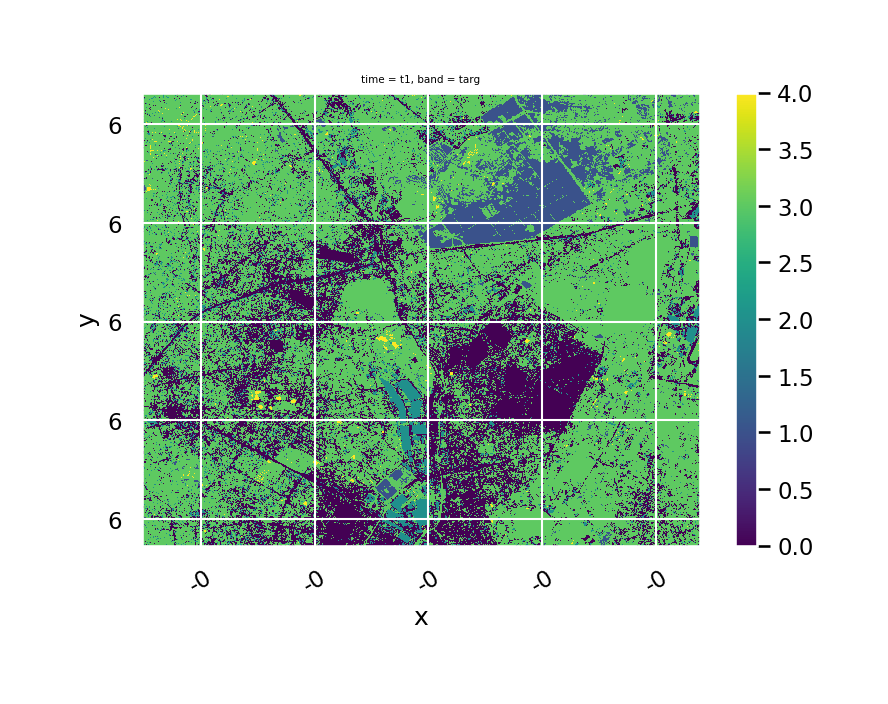

In [76]:
# Build pipeline
pipe = Pipeline([
            ('SimpleImputer', SimpleImputer(missing_values=np.nan, strategy="mean")),
            ('Featurizer', Featurizer()),
            ('scaler', StandardScaler()),
            ('rf', RandomForestClassifier(n_estimators=500, max_depth=500, max_features='auto', min_samples_split=3, n_jobs=-1))])

fp1 = ['./Data/img/B02.tiff','./Data/img/B03.tiff','./Data/img/B04.tiff', './Data/img/B08.tiff', './output/ndvi.tif']
with gw.config.update(ref_image=filelist1[0]):
    with gw.open(fp1, stack_dim= 'band', band_names=['BO2','B03','B04','B08','ndvi'] ) as src:
        y = fit_predict(src, lc, pipe, col='cat')
        y.sel(band='targ').gw.imshow()


# Gradient boosting 4 Bands + NDVI

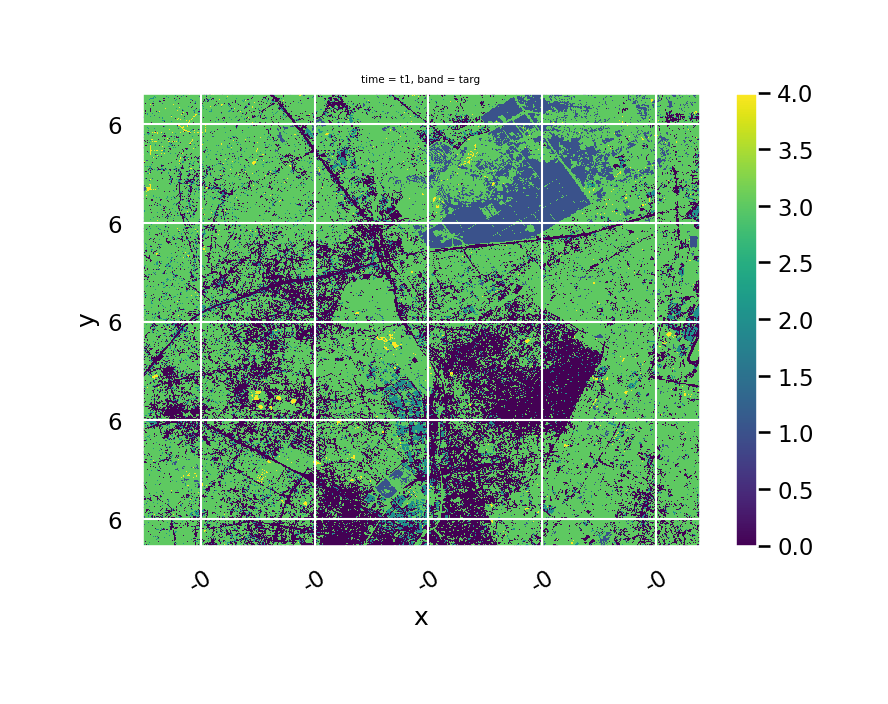

In [102]:
# Build pipeline
pipe = Pipeline([
            ('SimpleImputer', SimpleImputer(missing_values=np.nan, strategy="mean")),
            ('Featurizer', Featurizer()),
            ('scaler', StandardScaler()),
            ('gb', GradientBoostingClassifier())])

fp1 = ['./Data/img/B02.tiff','./Data/img/B03.tiff','./Data/img/B04.tiff', './Data/img/B08.tiff', './output/ndvi.tif']
with gw.config.update(ref_image=filelist1[0]):
    with gw.open(fp1, stack_dim= 'band', band_names=['BO2','B03','B04','B08','ndvi'] ) as src:
        y = fit_predict(src, lc, pipe, col='cat')
        y.sel(band='targ').gw.imshow()

# Random forest modeling 4 bands, NDVI and GIS data

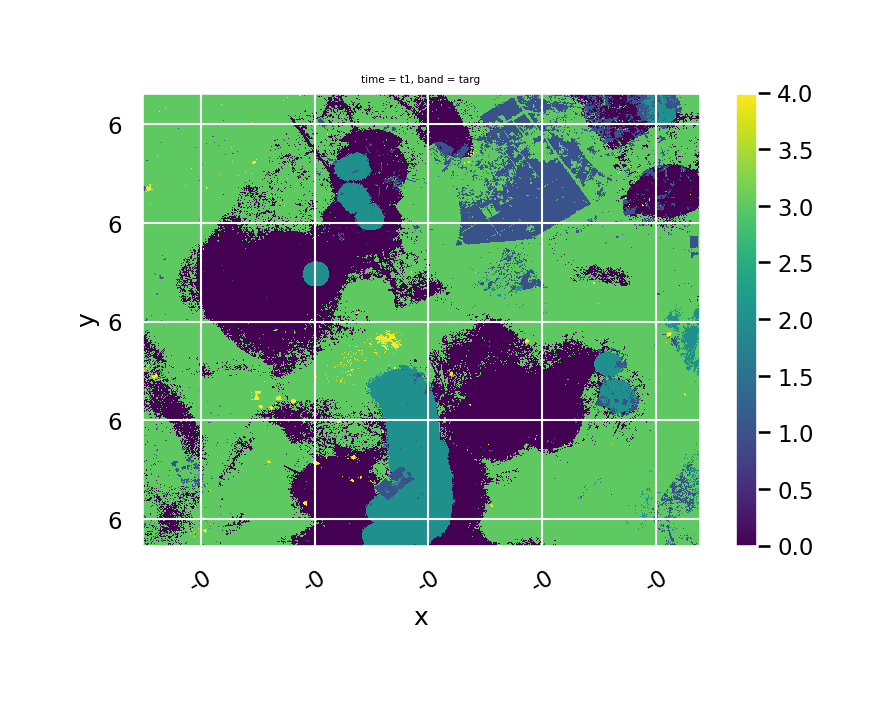

In [69]:
# Build pipeline
pipe = Pipeline([
            ('SimpleImputer', SimpleImputer(missing_values=np.nan, strategy="mean")),
            ('Featurizer', Featurizer()),
            ('scaler', StandardScaler()),
            ('rf', RandomForestClassifier(n_estimators=500, max_depth=500, max_features='auto', min_samples_split=3, n_jobs=-1))])


with gw.config.update(ref_image=filelist1[0]):
    with gw.open(fp, stack_dim= 'band', band_names=bandnames ) as src:
        y = fit_predict(src, lc, pipe, col='cat')
        y.sel(band='targ').gw.imshow()

# Gradient boosting modeling 4 bands, NDVI and GIS data

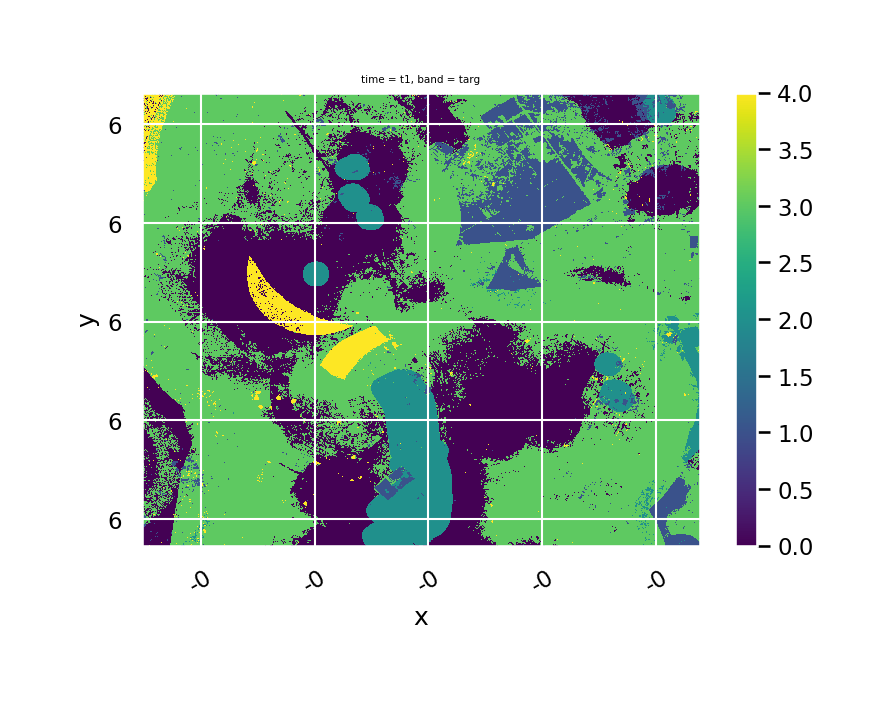

In [103]:
# Build pipeline
pipe = Pipeline([
            ('SimpleImputer', SimpleImputer(missing_values=np.nan, strategy="mean")),
            ('Featurizer', Featurizer()),
            ('scaler', StandardScaler()),
            ('gb', GradientBoostingClassifier())])

with gw.config.update(ref_image=filelist1[0]):
    with gw.open(fp, stack_dim= 'band', band_names=bandnames ) as src:
        y = fit_predict(src, lc, pipe, col='cat')
        y.sel(band='targ').gw.imshow()

# Conclusion

We have develop a semi-automated methods for detecting deprived areas using freely available sentinel-2 and OpenStreetMap data. the workflow is solely open source and relatively easy to reproduced. 

The logistic regression showed relationship between slum location and GIS data (euclidean distance). We observed positive slope for market and industry,and negetive slope for highways. 

We used histogram we assess the seperabilty of our trainset. we observed some form of overlapping as our classess are very similar. Visually, it is was difficult to distinguish as the classes look very similar.

We training our model using two classifier. Random forest and gradient boosting. they are known for handing complex datasets and good in prediction. The overall accuracy was very low in  both classifier. Both achieved an accuracy below 0.5. 

Surprisingly, the GIS data did not improve the models overall accuracy but proves to be useful as observed im the feature of imortance. 

Regarding limitation, it was difficult obtiaing representative training dataset for the model. Also, modeling at a spatial resolution of 10m proves to be challenging. 

Future work will add more GIS data since it proves to be use in classification (from feature of imporance). we can also add other contextual features to help capture the spatial patterns. 

